In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import duckdb

# Дано

Дан датасет с результатами асессорской разметки качества модели поиска дубликатов на маркетплейсе. В поле **answer** - результат сравнения карточек **parent_nm_id** и **duplicate_nm_id**. Пару карточек размечают на предмет "являются ли они дубликатами". Карточка - страница товара на маркетплейсе, например [так](https://www.wildberries.ru/catalog/231948542/detail.aspx). Некоторые товары может продавать несколько разных продавцов (пример покажу). Чтобы идентифицировать такое, есть модель поиска дубликатов, ее-то мы и будем оценивать. Каждую пару **parent_nm_id** и **duplicate_nm_id** оценивает три различных человека (такое называют "разметкой с перекрытием 3"), маркируются они по **executor_login**. Итоговый ответ выбирается путем простого голосования.


In [85]:
# открыли файл с разметками
df = pd.read_csv('duplicates_matching.csv')
df.head()

,dt,group_id,parent_nm_id,duplicate_nm_id,bucket_id,executor_login,answer,comment
0,2024-05-03,v1_2024-05-02,d32cb006dc6fe51a8711656978f2fd6d,b54983c6c3c93f0d6e1a1796115c868f,"3,4,5",2e135b08d65255fc4c0386c0c471a0b3,Дубликаты,NaN
1,2024-05-03,v1_2024-05-02,d32cb006dc6fe51a8711656978f2fd6d,b54983c6c3c93f0d6e1a1796115c868f,"3,4,5",f028c5ec87044b4b7c7670bea1780ae5,Дубликаты,NaN
2,2024-05-03,v1_2024-05-02,d32cb006dc6fe51a8711656978f2fd6d,b54983c6c3c93f0d6e1a1796115c868f,"3,4,5",4242a2448d1e903afaa66da1c8a83390,Дубликаты,NaN
3,2024-05-03,v1_2024-05-02,9177fd909644e4466b81be0544afbe95,2cc66fc06ceddeb5a7355279c420fec7,"1,2",34dceb77fd160d53131640504274a25b,Скип,NaN
4,2024-05-03,v1_2024-05-02,9177fd909644e4466b81be0544afbe95,2cc66fc06ceddeb5a7355279c420fec7,"1,2",34dceb77fd160d53131640504274a25b,Дубликаты,NaN


In [86]:
#  Какие есть типы ответов
df.answer.unique()

array(['Дубликаты', 'Скип', 'Не дубликаты'], dtype=object)

In [87]:
# Скипы уберем
df[df.answer!= 'Скип'].shape

(31859, 8)

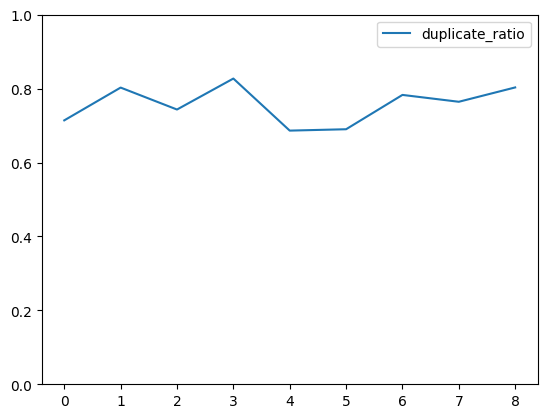

In [88]:
# Доля дубликатов в разметке по дням

q = '''
SELECT dt, avg(duplicate_flg) as duplicate_ratio
FROM (select dt,
        parent_nm_id, duplicate_nm_id,
        CASE WHEN count_if(answer = 'Дубликаты') >= 2 THEN 1
            ELSE 0 END AS duplicate_flg
    FROM df
    group by dt, parent_nm_id, duplicate_nm_id
    having count(distinct answer) != 3
        and count_if(answer = 'Скип') < 2
    ) as a
GROUP BY dt
ORDER BY dt
'''


_ = duckdb.query(q).to_df().plot(ylim = (0,1))

# Подсчет метрики

Метрика у нас оценивается "с перекрытием"(три человека на единицу разметки). В итоговую оценку НЕ включаются ответы "три ответа разные" и "два ответа скип". Для случая разметки "без перекрытия" мы просто берем случайные единицы, а потом для каждой из них - случайного асессора.


# Задание

С помощью непараметрического бутстрепа постройте доверительный интервал для разницы долей ответов "Дубликаты" в случае оценки метрики на выборке размера 2500 с перекрытием и на метрике 5000 - без перекрытия. 

\+ пояснение будет дано на лекции :)

# P.S. Это АБСОЛЮТНО реальная задача на абсолютно реальных данных
